<a href="https://colab.research.google.com/github/jinchuangtw/traffic-sign-classifier/blob/main/traffic_sign_classifier_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Sign Classifier
## 前置作業
1. 掛載 Google 雲端硬碟。由於後續會用到各種 .p files，這邊直接用掛載的就不用每次手動上傳檔案。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import 相關套件

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random
import cv2

## 初始化亂數種子
這步可以固定每次隨機生成的東西

In [ ]:
np.random.seed(0)

## 讀入檔案
Pickle 這個套件可以幫助使用者讀寫 deep learning 時會用到的各種資料集。這邊就是把檔案讀進來，然後設定好相關變數。
x指的是輸入，y是輸出(label)。
例如輸入某張狗狗圖片叫做 x_1，類神經網路就輸出 y_1 = 狗。另外，資料及總共有三份，包括訓練用的、驗證用的跟測試用的。

In [ ]:
with open('/content/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('/content/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('/content/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
  
  
X_train , y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

印出資料集的大小。

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


檢查一下資料集的輸入跟輸出數量都一致(每份資料集裡面有多少input就要有多少output)，以及image size是否正確。

In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "No. of Images is not equals to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "No. of Images is not equals to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is not equals to number of labels"

assert(X_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"

隨機印出幾張資料集中的影像以及他們對應到的label

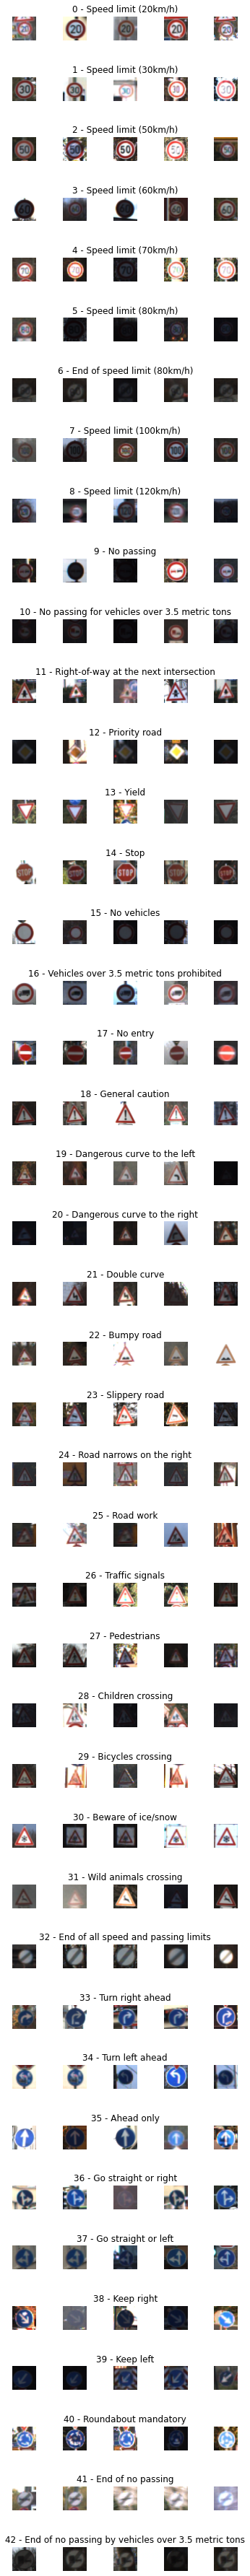

In [ ]:
data = pd.read_csv('signnames.csv')
#print(data)

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

印出並確認資料集裡面各個labels的分布狀態

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


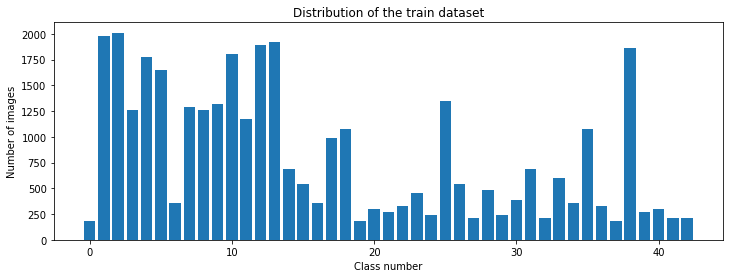

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

印一下測試集中第2000張圖片、它的大小，以及它屬於哪一個label

(32, 32, 3)
23


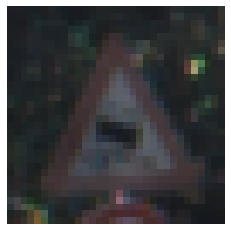

In [ ]:
plt.imshow(X_train[2000], cmap = plt.get_cmap('gray'))
plt.axis("off")
print(X_train[2000].shape)
print(y_train[2000])

把剛剛的圖轉灰階

(32, 32)


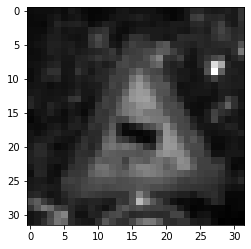

In [ ]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[2000])
plt.imshow(img, cmap = plt.get_cmap('gray'))
#plt.axis("off")
print(img.shape)

做個正規化

(32, 32)


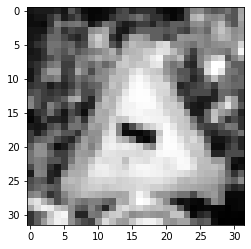

In [ ]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img


img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

把剛剛那兩步(轉灰階、正規化)包成一個function叫做preprocessing，待會就可以利用這個function處理所有圖片

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  #normalize the images, i.e. convert the pixel values to fit btwn 0 and 1
  img = img/255
  return img

開始處理! 三包資料集都要~

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

隨機印出一張 發現 恩~轉灰階跟正規化都做好了呢

(34799, 32, 32)


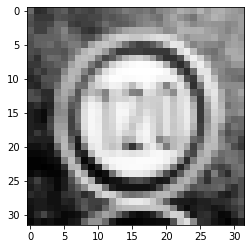

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap = plt.get_cmap('gray'))
print(X_train.shape)

這步 看不懂(或許是要把原本占了3個channel的RGB圖片轉成1個channel)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

下面這步是把原本的影像做個隨機轉換(往左移一點 旋轉一下 縮放一下 之類的)有助於提升模型強度

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

設定待會訓練時的batch要多大，然後印出來確定一下

(15, 32, 32, 1)


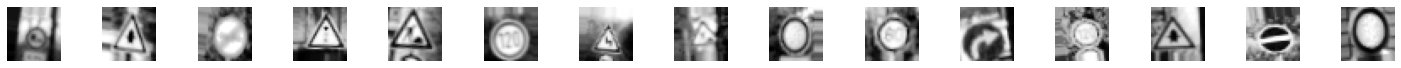

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32), cmap = plt.get_cmap('gray'))
    axs[i].axis("off")

print(X_batch.shape)

確認一下恩恩都已經轉成(32, 32, 1)ㄌ

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


不是很確定不過這邊應該只是把每個label依序給定編號(1~43)

In [ ]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

刻出LeNet
(很抱歉無法詳細解釋)

In [ ]:
def lenet_model():
  model = Sequential()
  # add the convolutional layer
  #filters, size of filters,input_shape,activation_function
  model.add(Conv2D(60,(5,5), input_shape= (32,32,1), activation = 'relu'))
  model.add(Conv2D(60,(5,5), input_shape= (32,32,1), activation = 'relu'))
  #pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  # add another convolutional layer
  model.add(Conv2D(30, (3, 3) , activation = 'relu'))
  model.add(Conv2D(30, (3, 3) , activation = 'relu'))
  # pooling layer
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  #model.add(Dropout(0.5))
  
  #Flatten the image to 1 dimensional array
  model.add(Flatten())
  #add a dense layer : amount of nodes, activation
  model.add(Dense(500, activation = 'relu'))
  # place a dropout layer
  #0.5 drop out rate is recommended, half input nodes will be dropped at each update
  model.add(Dropout(0.5))
  # defining the ouput layer of our network
  model.add(Dense(num_classes, activation = 'softmax'))
  
  
  #Compile Model
  # we use Adam optimizer with a learning rate 0f 0.01
  # A categorical_crossentropy'
  
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return model

把建立好的model印出來確認一下

In [ ]:
model = lenet_model()
#print a summary of the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


開始 train(這邊把batch_size設定為100，並共有20個epochs)

In [ ]:
# define our training paramters
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=100),
                            steps_per_epoch=200,
                            epochs=20,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


200/200 [==============================] - 18s 34ms/step - loss: 2.6995 - accuracy: 0.2626 - val_loss: 0.9414 - val_accuracy: 0.7379
Epoch 2/20
200/200 [==============================] - 7s 33ms/step - loss: 1.0980 - accuracy: 0.6640 - val_loss: 0.3308 - val_accuracy: 0.9093
Epoch 3/20
200/200 [==============================] - 7s 33ms/step - loss: 0.6568 - accuracy: 0.7972 - val_loss: 0.1902 - val_accuracy: 0.9408
Epoch 4/20
200/200 [==============================] - 7s 33ms/step - loss: 0.4856 - accuracy: 0.8514 - val_loss: 0.1180 - val_accuracy: 0.9687
Epoch 5/20
200/200 [==============================] - 6s 32ms/step - loss: 0.3735 - accuracy: 0.8872 - val_loss: 0.0923 - val_accuracy: 0.9739
Epoch 6/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2956 - accuracy: 0.9057 - val_loss: 0.0789 - val_accuracy: 0.9755
Epoch 7/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2470 - accuracy: 0.9237 - val_loss: 0.0682 - val_accuracy: 0.9805
Epoch 8/2

印出 training 時 loss 收斂的過程

Text(0.5, 0, 'epoch')

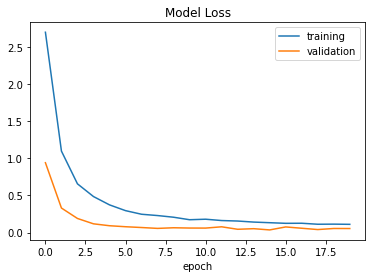

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('epoch')

印出 accuracy

Text(0.5, 0, 'epoch')

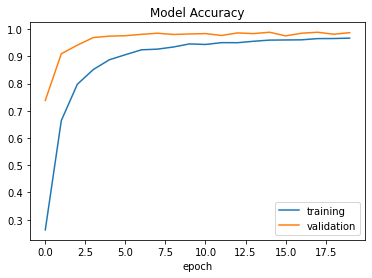

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Model Accuracy')
plt.xlabel('epoch')

印出詳細數值(剛剛兩張圖表最後收斂的值)

In [ ]:
score = model.evaluate(X_test, y_test)
print("The loss score is: ",score[0])
print("The Accuracy score is: ",score[1])

395/395 [==============================] - 2s 4ms/step - loss: 0.1773 - accuracy: 0.9583
The loss score is:  0.17734597623348236
The Accuracy score is:  0.9582739472389221


模型訓練好之後 就可以拿別的圖片來看看這模型可不可以準確預測出這個traffic sign是哪一個。所以我們先抓一張圖然後顯示他。

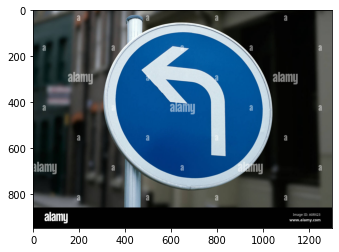

In [ ]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

對這張圖片進行前處理

(32, 32)


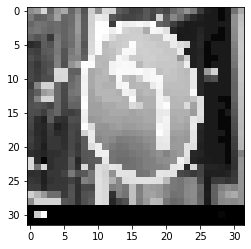

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

跟一開始一樣 做完前處理就reshape一下

In [ ]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

餵進去網路 看輸出哪個label

In [ ]:
#Test image
predict = model.predict(img)
predict = np.argmax(predict,axis=1)
print("The Predicted sign: "+ str(predict))

The Predicted sign: [38]


把 train 好的 model 存起來

In [ ]:
from keras.models import load_model

model.save('traffic_sign_classifier_model.h5')  # creates a HDF5 file 'my_model.h5'
del model # deletes the existing model

再載入他(為何XDD???)

In [ ]:
# returns a compiled model
# identical to the previous one
from keras.models import load_model
model = load_model('traffic_sign_classifier_model.h5')

一樣抓圖

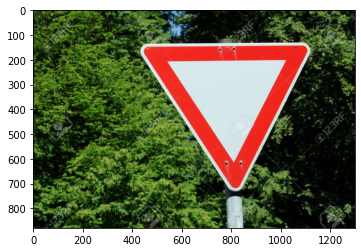

In [ ]:
#fetch image

import requests
from PIL import Image
url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

前處理

(32, 32)


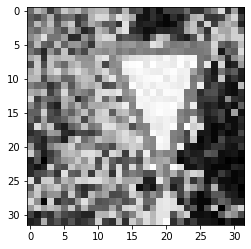

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

丟進model看結果

In [ ]:
#Test image
predict = model.predict(img)
predict = np.argmax(predict,axis=1)
print("The Predicted sign: "+ str(predict))

The Predicted sign: [13]


最後一張 都是一樣的動作

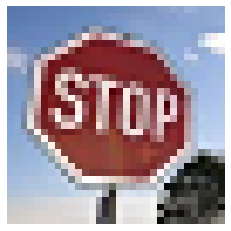

In [ ]:
img = cv2.imread("3.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape #(512, 512, 3)
plt.imshow(img) # 顯示圖片
plt.axis('off') # 不顯示座標軸
plt.show()

(32, 32)


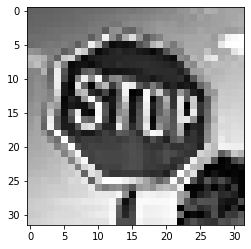

In [ ]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [ ]:
#Test image
predict = model.predict(img)
predict = np.argmax(predict,axis=1)
print("The Predicted sign: "+ str(predict))

The Predicted sign: [14]
